<a href="https://colab.research.google.com/github/plancute/python/blob/master/deeplearning/code/09_%EC%98%A4%EC%B0%A8%EC%97%AD%EC%A0%84%ED%8C%8C_%EB%B0%8F_%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8장 오차 역전파 (110-113p)


![python image2](https://thebook.io/img/080228/117_1.jpg)
![python image2](https://thebook.io/img/080228/117_2.jpg)

오차역전파 구동방식 <br>
1, 임의의 초기 가중치(W)를 준 뒤 결과(Yout)를 계산한다. <br>
2. 계산 결과와 우리가 원하는 값 사이의 오차를 구한다. <br>
3. 경사 하강법을 이용해 바로 앞 가중치를 오차가 작아지는 방향으로 업데이트 한다. <br>
4. 위 과정을 더이상 오차가 줄어들지 않을 때까지 반복한다. <br>

# 부록 B 심화학습 2: 파이썬 코드로 확인하는 신경망 (273-282p)

In [1]:
# -*- coding: utf-8 -*-

import random
import numpy as np

random.seed(777)

# 환경 변수 지정

# 입력값 및 타겟값
data = [
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
]

In [3]:
# 실행 횟수(iterations), 학습률(lr), 모멘텀 계수(mo) 설정
iterations=5000
lr=0.1
mo=0.9

# 활성화 함수 - 1. 시그모이드
# 미분할 때와 아닐 때의 각각의 값
def sigmoid(x, derivative=False):
    if (derivative == True):
        return x * (1 - x)
    return 1 / (1 + np.exp(-x))

# 활성화 함수 - 2. tanh
# tanh 함수의 미분은 1 - (활성화 함수 출력의 제곱)
def tanh(x, derivative=False):
    if (derivative == True):
        return 1 - x ** 2
    return np.tanh(x)

# 가중치 배열 만드는 함수
def makeMatrix(i, j, fill=0.0):
    mat = []
    for i in range(i):
        mat.append([fill] * j)
    return mat


In [4]:
# 신경망의 실행
class NeuralNetwork:

    # 초깃값의 지정
    def __init__(self, num_x, num_yh, num_yo, bias=1):

        # 입력값(num_x), 은닉층 초깃값(num_yh), 출력층 초깃값(num_yo), 바이어스
        self.num_x = num_x + bias  # 바이어스는 1로 지정(본문 참조)
        self.num_yh = num_yh
        self.num_yo = num_yo

        # 활성화 함수 초깃값
        self.activation_input = [1.0] * self.num_x
        self.activation_hidden = [1.0] * self.num_yh
        self.activation_out = [1.0] * self.num_yo

        # 가중치 입력 초깃값
        self.weight_in = makeMatrix(self.num_x, self.num_yh)
        for i in range(self.num_x):
            for j in range(self.num_yh):
                self.weight_in[i][j] = random.random()

        # 가중치 출력 초깃값
        self.weight_out = makeMatrix(self.num_yh, self.num_yo)
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                self.weight_out[j][k] = random.random()

        # 모멘텀 SGD를 위한 이전 가중치 초깃값
        self.gradient_in = makeMatrix(self.num_x, self.num_yh)
        self.gradient_out = makeMatrix(self.num_yh, self.num_yo)

    # 업데이트 함수
    def update(self, inputs):

        # 입력 레이어의 활성화 함수
        for i in range(self.num_x - 1):
            self.activation_input[i] = inputs[i]

        # 은닉층의 활성화 함수
        for j in range(self.num_yh):
            sum = 0.0
            for i in range(self.num_x):
                sum = sum + self.activation_input[i] * self.weight_in[i][j]
            # 시그모이드와 tanh 중에서 활성화 함수 선택
            self.activation_hidden[j] = tanh(sum, False)

        # 출력층의 활성화 함수
        for k in range(self.num_yo):
            sum = 0.0
            for j in range(self.num_yh):
                sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
            # 시그모이드와 tanh 중에서 활성화 함수 선택
            self.activation_out[k] = tanh(sum, False)

        return self.activation_out[:]
    
    # 역전파의 실행
    def backPropagate(self, targets):

        # 델타 출력 계산
        output_deltas = [0.0] * self.num_yo
        for k in range(self.num_yo):
            error = targets[k] - self.activation_out[k]
            # 시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            output_deltas[k] = tanh(self.activation_out[k], True) * error

        # 은닉 노드의 오차 함수
        hidden_deltas = [0.0] * self.num_yh
        for j in range(self.num_yh):
            error = 0.0
            for k in range(self.num_yo):
                error = error + output_deltas[k] * self.weight_out[j][k]
                # 시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            hidden_deltas[j] = tanh(self.activation_hidden[j], True) * error

        # 출력 가중치 업데이트
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                gradient = output_deltas[k] * self.activation_hidden[j]
                v = mo * self.gradient_in[j][k] - lr * gradient
                self.weight_in[j][k] += v
                self.gradient_out[j][k] = gradient

        # 입력 가중치 업데이트
        for i in range(self.num_x):
            for j in range(self.num_yh):
                gradient = hidden_deltas[j] * self.activation_input[i]
                v = mo*self.gradient_in[i][j] - lr * gradient
                self.weight_in[i][j] += v
                self.gradient_in[i][j] = gradient

        # 오차의 계산(최소 제곱법)
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5 * (targets[k] - self.activation_out[k]) ** 2
        return error

    # 학습 실행
    def train(self, patterns):
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets)
            if i % 500 == 0:
                print('error: %-.5f' % error)
    # 결괏값 출력
    def result(self, patterns):
        for p in patterns:
            print('Input: %s, Predict: %s' % (p[0], self.update(p[0])))



In [5]:
if __name__ == '__main__':

    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork(2, 2, 1)

    # 학습 실행
    n.train(data)

    # 결괏값 출력
    n.result(data)


# Reference: http://arctrix.com/nas/python/bpnn.py (Neil Schemenauer)


error: 0.67409
error: 0.00908
error: 0.00629
error: 0.00534
error: 0.00485
error: 0.00456
error: 0.00437
error: 0.00424
error: 0.00414
error: 0.00407
Input: [0, 0], Predict: [0.02205037348028232]
Input: [0, 1], Predict: [0.9397971425282383]
Input: [1, 0], Predict: [0.9421145997321853]
Input: [1, 1], Predict: [0.02405264543901786]


# 9장 신경망에서 딥러닝으로 (114-120p)

오차 역전파를 통해 출력층으로부터 하나씩 앞으로 되돌아가며 각 층의 가중치를 수정할 때, 가중치를 수정하려면 미분값이 필요하다. <br>
그런데 층이 늘어나면서 기울기가 0 이 되버리는 기울기 소실이 발생한다. <br>
시그모이드 함수 미분값은 최대치가 0.3 이며 1보다 작으므로 계속 곱하다 보면 0에 가까워진다. <br>
이를 해결하고자 활성화 함수를 다른 함수로 대체하기 시작하였다. <br>
* 딥러닝에서 ReLU를 많이 사용한다.

* 대표적인 활성화 함수

![python image2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FNez8m%2FbtqBQoxpE4Z%2FYvKeF07hh7fR3qbkmymKq0%2Fimg.png)

In [ ]:
import numpy as np
import matplotlib.pylab as plt

def sigmoid_func(x): # 시그모이드(Sigmoid, S자모양) 대표적인 함수
    return 1 / (1 + np.exp(-x))

def sigmoid_d_func(x): # 시그모이드 미분
    return sigmoid_func(x)*(1-sigmoid_func(x))

def tanh_func(x): # TanH 함수
    return np.tanh(x)
    # return 2 / (1 + np.exp(-2*x)) - 1 # same

def tanh_d_func(x): # TanH 미분
    return (1-np.tanh(x))*(1+np.tanh(x))
    
def relu_func(x): # ReLU(Rectified Linear Unit, 정류된 선형 유닛) 함수
    return (x>0)*x
    # return np.maximum(0,x) # same

def relu_d_func(x): # ReLU 미분 (x가 0 이상일때는 1, 0 미만일때는 0)
    return (x>0)*1

def softplus_func(x): # SoftPlus 함수
    return np.log( 1 + np.exp(x) )

def softplus_d_func(x): # SoftPlus 미분 (= 시그모이드 함수)
    return sigmoid_func(x)

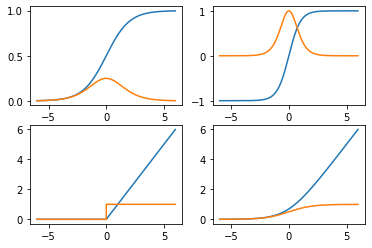

In [ ]:
# 모두의 딥러닝 책 116 page
# 더 많은 활성함수 : https://subinium.github.io/introduction-to-activation/
plt.subplot(221)
plt.plot(x, sigmoid_func(x))
plt.plot(x, sigmoid_d_func(x))
plt.subplot(222)
plt.plot(x, tanh_func(x))
plt.plot(x, tanh_d_func(x))
plt.subplot(223)
plt.plot(x, relu_func(x))
plt.plot(x, relu_d_func(x))
plt.subplot(224)
plt.plot(x, softplus_func(x))
plt.plot(x, softplus_d_func(x))
plt.show()

========================= EOF =========================